<a href="https://colab.research.google.com/github/satyajitghana/TSAI-DeepVision-EVA4.0-Phase-2/blob/master/08-SuperResolution_StyleTransfer/IFO_SuperResolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! nvidia-smi

Fri Oct  9 16:38:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    42W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Identified Flying Object - Super Resolution

In [2]:
from torch.utils.data import Dataset, Subset, DataLoader
import numpy as np
import os
import random
import copy
import gdown
from PIL import Image
import torch
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import torch
from torchsummary import summary
from pathlib import Path
from zipfile import ZipFile
from pprint import pprint
import json
import torch.optim as optim
from torchvision.models.vgg import vgg16
import torchvision.transforms as T
import matplotlib.pyplot as plt
import albumentations as A
import albumentations.pytorch.transforms as AT
from tqdm.auto import tqdm
import seaborn as sns
sns.set()

In [3]:
url = 'https://drive.google.com/uc?id=1LXbEadbpuvTJVwj5thGrlMjYP9hzt6Wn'
output = 'IFOCleaned.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1LXbEadbpuvTJVwj5thGrlMjYP9hzt6Wn
To: /content/IFOCleaned.zip
267MB [00:00, 332MB/s]


'IFOCleaned.zip'

dataset image size: `500x500`

train crop: `400x400`

upscale factor = `2`



## Dataset

Transforms

In [4]:
class IFODataset(Dataset):
    """ 
        Dataset generator for MobileNetV2 implementation on Identified
        flying objects dataset
    """
    
    class_names = ['Flying_Birds', 'Large_QuadCopters', 'Small_QuadCopters', 'Winged_Drones']

    def __init__(self, root, source_zipfile, transform=None, target_transform=None):

        self.root = Path(root) / 'IFO'
        self.root.mkdir(parents=True, exist_ok=True)
        self.source_zipfile = Path(source_zipfile)
        self.transform = transform

        if os.path.isdir(self.root / 'IFOCleaned'):
            print(f"dataset folder/files already exist in {self.root / 'IFOCleaned'}")
        else:
            self.extractall()

        self.images_paths = sorted(list(Path(self.root / 'IFOCleaned').glob('*/*.jpg')))
        self.targets = [self.class_names.index(image_path.parent.name) for image_path in self.images_paths]

        print(f'found {len(self.images_paths)} images in total')
        l = list(self.targets)
        images_per_class = dict((self.class_names[x],l.count(x)) for x in set(l))
        print(json.dumps(images_per_class, indent=4))
    
    def extractall(self):
        print('Extracting the dataset zip file')
        zipf = ZipFile(self.source_zipfile, 'r')
        zipf.extractall(self.root)

    @staticmethod
    def split_dataset(dataset, train_transform_builder, test_transform_builder):
        # split indices to train and test, use stratify to distribute equally
        train_idxs, test_idxs = train_test_split(np.arange(len(dataset.images_paths)), test_size=0.3, shuffle=True, stratify=dataset.targets)

        train_set = copy.deepcopy(dataset)
        train_set.transform, train_set.target_transform = train_transform_builder()
        
        test_set = copy.deepcopy(dataset)
        test_set.transform, test_set.target_transform = test_transform_builder()

        return Subset(train_set, indices=train_idxs), Subset(test_set, test_idxs)
    
    def __len__(self):
        return len(self.images_paths)
    
    def __getitem__(self, index):

        image_path = self.images_paths[index]
        image = Image.open(image_path)
        image = image.convert('RGB')

        target = image
        
        if self.transform:
            image = self.transform(image)
        
        if self.target_transform:
            target = self.target_transform(image)

        return target, image

In [45]:
CROP_SIZE = 200         # [100, 200, 400]
UPSCALE_FACTOR = 2      # [2, 4, 8, 16]
IMAGE_SIZE = 250

def build_train_transforms():
    transform = T.Compose([
                           T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                           T.RandomCrop((CROP_SIZE, CROP_SIZE)),
                           T.ToTensor(),
                           ])
    
    target_transform = T.Compose([
                                  T.ToPILImage(),
                                  T.Resize((CROP_SIZE//UPSCALE_FACTOR, CROP_SIZE//UPSCALE_FACTOR), interpolation=Image.BICUBIC),
                                  T.ToTensor()
                                  ])
    
    return transform, target_transform

def build_test_transforms():
    transform = T.Compose([
                           T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                           T.CenterCrop((CROP_SIZE, CROP_SIZE)),
                           T.ToTensor(),
                           ])
    
    target_transform = T.Compose([
                                  T.ToPILImage(),
                                  T.Resize((CROP_SIZE//UPSCALE_FACTOR, CROP_SIZE//UPSCALE_FACTOR), interpolation=Image.BICUBIC),
                                  T.ToTensor()
                                  ])
    
    return transform, target_transform


In [46]:
dataset = IFODataset(root='data', source_zipfile='IFOCleaned.zip')

dataset folder/files already exist in data/IFO/IFOCleaned
found 22193 images in total
{
    "Flying_Birds": 8164,
    "Large_QuadCopters": 4886,
    "Small_QuadCopters": 3612,
    "Winged_Drones": 5531
}


In [7]:
trainset, testset = IFODataset.split_dataset(dataset, build_train_transforms, build_test_transforms)

In [8]:
dataloader = DataLoader(testset, batch_size=16, shuffle=True, num_workers=1)

In [9]:
batch = iter(dataloader)
next_batch = next(batch)

In [10]:
next_batch[0].shape, next_batch[1].shape

(torch.Size([16, 3, 400, 400]), torch.Size([16, 3, 100, 100]))

(-0.5, 399.5, 399.5, -0.5)

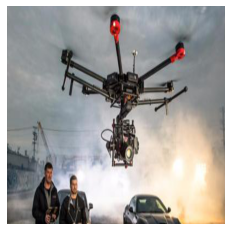

In [11]:
plt.imshow(next_batch[0][0].permute(1, 2, 0).cpu().numpy())
plt.axis('off')

(-0.5, 99.5, 99.5, -0.5)

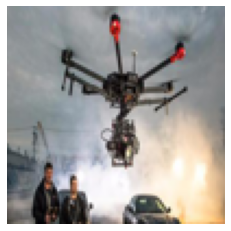

In [12]:
plt.imshow(next_batch[1][0].permute(1, 2, 0).cpu().numpy())
plt.axis('off')

In [13]:
def plot_batch(batch):
    fig = plt.figure(figsize=(25, 10))
    images, targets = batch
    print(images.shape, targets.shape)
    
    for i in range(6):
        plt.subplot(2, 6, i + 1)
        img, target = images[i], targets[i]
        plt.imshow(img.permute(1, 2, 0).cpu().numpy())
        plt.axis('off')
        plt.subplot(2, 6, i + 6 + 1)
        plt.imshow(target.permute(1, 2, 0).cpu().numpy())
        plt.axis('off')

torch.Size([16, 3, 400, 400]) torch.Size([16, 3, 100, 100])


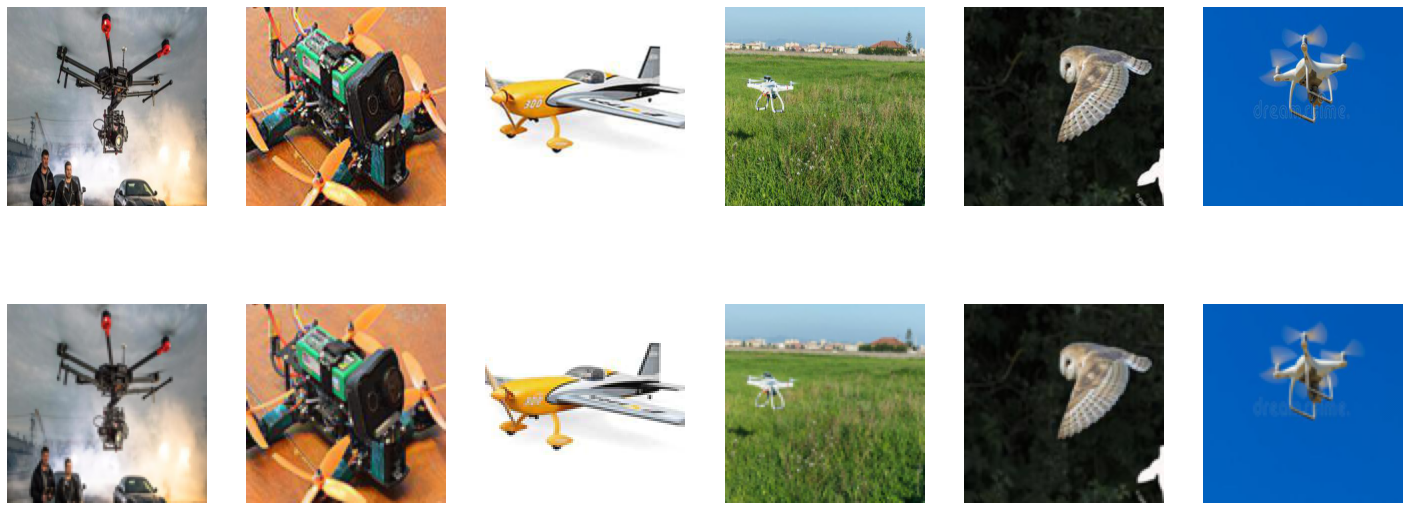

In [14]:
plot_batch(next_batch)

## Model

In [7]:
import math
import torch
from torch import nn


class Generator(nn.Module):
    def __init__(self, scale_factor):
        upsample_block_num = int(math.log(scale_factor, 2))

        super(Generator, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.PReLU()
        )
        self.block2 = ResidualBlock(64)
        self.block3 = ResidualBlock(64)
        self.block4 = ResidualBlock(64)
        self.block5 = ResidualBlock(64)
        self.block6 = ResidualBlock(64)
        self.block7 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
        )
        block8 = [UpsampleBLock(64, 2) for _ in range(upsample_block_num)]
        block8.append(nn.Conv2d(64, 3, kernel_size=9, padding=4))
        self.block8 = nn.Sequential(*block8)

    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)
        block6 = self.block6(block5)
        block7 = self.block7(block6)
        block8 = self.block8(block1 + block7)

        return (torch.tanh(block8) + 1) / 2


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(512, 1024, kernel_size=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(1024, 1, kernel_size=1)
        )

    def forward(self, x):
        batch_size = x.size(0)
        return torch.sigmoid(self.net(x).view(batch_size))


class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.prelu(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)

        return x + residual


class UpsampleBLock(nn.Module):
    def __init__(self, in_channels, up_scale):
        super(UpsampleBLock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(up_scale)
        self.prelu = nn.PReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)
        return x

In [40]:
netG = Generator(UPSCALE_FACTOR)
netD = Discriminator()

In [41]:
summary(netG, (3, CROP_SIZE//UPSCALE_FACTOR, CROP_SIZE//UPSCALE_FACTOR), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 200, 200]          15,616
             PReLU-2         [-1, 64, 200, 200]               1
            Conv2d-3         [-1, 64, 200, 200]          36,928
       BatchNorm2d-4         [-1, 64, 200, 200]             128
             PReLU-5         [-1, 64, 200, 200]               1
            Conv2d-6         [-1, 64, 200, 200]          36,928
       BatchNorm2d-7         [-1, 64, 200, 200]             128
     ResidualBlock-8         [-1, 64, 200, 200]               0
            Conv2d-9         [-1, 64, 200, 200]          36,928
      BatchNorm2d-10         [-1, 64, 200, 200]             128
            PReLU-11         [-1, 64, 200, 200]               1
           Conv2d-12         [-1, 64, 200, 200]          36,928
      BatchNorm2d-13         [-1, 64, 200, 200]             128
    ResidualBlock-14         [-1, 64, 2

In [42]:
summary(netD, (3, CROP_SIZE, CROP_SIZE), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 400, 400]           1,792
         LeakyReLU-2         [-1, 64, 400, 400]               0
            Conv2d-3         [-1, 64, 200, 200]          36,928
       BatchNorm2d-4         [-1, 64, 200, 200]             128
         LeakyReLU-5         [-1, 64, 200, 200]               0
            Conv2d-6        [-1, 128, 200, 200]          73,856
       BatchNorm2d-7        [-1, 128, 200, 200]             256
         LeakyReLU-8        [-1, 128, 200, 200]               0
            Conv2d-9        [-1, 128, 100, 100]         147,584
      BatchNorm2d-10        [-1, 128, 100, 100]             256
        LeakyReLU-11        [-1, 128, 100, 100]               0
           Conv2d-12        [-1, 256, 100, 100]         295,168
      BatchNorm2d-13        [-1, 256, 100, 100]             512
        LeakyReLU-14        [-1, 256, 1

## Loss Functions

In [8]:
class GeneratorLoss(nn.Module):
    def __init__(self, device):
        super(GeneratorLoss, self).__init__()
        self.device = device
        vgg = vgg16(pretrained=True)
        vgg = vgg.to(device)

        loss_network = nn.Sequential(*list(vgg.features)[:31]).eval()
        for param in loss_network.parameters():
            param.requires_grad = False
        self.loss_network = loss_network
        self.mse_loss = nn.MSELoss()
        self.tv_loss = TVLoss()

    def forward(self, out_labels, out_images, target_images):
        # Adversarial Loss
        adversarial_loss = torch.mean(1 - out_labels)
        # Perception Loss

        # print(out_images.shape, target_images.shape)
        # print(self.loss_network(out_images).shape, self.loss_network(target_images).shape)
        perception_loss = self.mse_loss(self.loss_network(out_images), self.loss_network(target_images))
        # Image Loss
        image_loss = self.mse_loss(out_images, target_images)
        # TV Loss
        tv_loss = self.tv_loss(out_images)
        return image_loss + 0.001 * adversarial_loss + 0.006 * perception_loss + 2e-8 * tv_loss


class TVLoss(nn.Module):
    def __init__(self, tv_loss_weight=1):
        super(TVLoss, self).__init__()
        self.tv_loss_weight = tv_loss_weight

    def forward(self, x):
        batch_size = x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]
        count_h = self.tensor_size(x[:, :, 1:, :])
        count_w = self.tensor_size(x[:, :, :, 1:])
        h_tv = torch.pow((x[:, :, 1:, :] - x[:, :, :h_x - 1, :]), 2).sum()
        w_tv = torch.pow((x[:, :, :, 1:] - x[:, :, :, :w_x - 1]), 2).sum()
        return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size

    @staticmethod
    def tensor_size(t):
        return t.size()[1] * t.size()[2] * t.size()[3]

In [21]:
from math import exp

import torch
import torch.nn.functional as F
from torch.autograd import Variable


def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size // 2) ** 2 / float(2 * sigma ** 2)) for x in range(window_size)])
    return gauss / gauss.sum()


def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window


def _ssim(img1, img2, window, window_size, channel, size_average=True):
    mu1 = F.conv2d(img1, window, padding=window_size // 2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size // 2, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size // 2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size // 2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=window_size // 2, groups=channel) - mu1_mu2

    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)


class SSIM(torch.nn.Module):
    def __init__(self, window_size=11, size_average=True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)

            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)

            self.window = window
            self.channel = channel

        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)


def ssim(img1, img2, window_size=11, size_average=True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)

    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)

    return _ssim(img1, img2, window, window_size, channel, size_average)

## Train the Model

In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [70]:
trainset, testset = IFODataset.split_dataset(dataset, build_train_transforms, build_test_transforms)

In [71]:
BATCH_SIZE = 32
train_loader, test_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True),\
                            DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

In [72]:
netG = Generator(UPSCALE_FACTOR)
netD = Discriminator()

In [73]:
netG = netG.to(device) # generator
netD = netD.to(device) # discriminator

optimizerG = optim.Adam(netG.parameters())
optimizerD = optim.Adam(netD.parameters())

generator_criterion = GeneratorLoss(device) # loss function

In [74]:
for data, target in train_loader:
    print(data.shape, target.shape)
    break

torch.Size([32, 3, 100, 100]) torch.Size([32, 3, 200, 200])


In [75]:
results = {'d_loss': [], 'g_loss': [], 'd_score': [], 'g_score': [], 'psnr': [], 'ssim': []}

In [76]:
import torch, gc
from math import log10

NUM_EPOCHS = 5
for epoch in tqdm(range(1, NUM_EPOCHS + 1)):
    running_results = {'batch_sizes': 0, 'd_loss': 0, 'g_loss': 0, 'd_score': 0, 'g_score': 0}
    train_bar = tqdm(train_loader, dynamic_ncols=True)

    netG.train()
    netD.train()

    for data, target in train_bar:
        data, target = data.to(device), target.to(device)

        batch_size = data.size(0)
        running_results['batch_sizes'] += batch_size

        ############################
        # (1) Update D network: maximize D(x)-1-D(G(z))
        ###########################
        real_img = target
        z = data
        fake_img = netG(z)

        netD.zero_grad()
        real_out = netD(real_img).mean()
        fake_out = netD(fake_img).mean()
        d_loss = 1 - real_out + fake_out

        d_loss.backward()
        optimizerD.step()

        ############################
        # (2) Update G network: minimize 1-D(G(z)) + Perception Loss + Image Loss + TV Loss
        ###########################
        netG.zero_grad()
        ##############################################################
        ## The two lines below are added to prevent runetime error! ##
        fake_img = netG(z)
        fake_out = netD(fake_img).mean()
        ##############################################################
        g_loss = generator_criterion(fake_out, fake_img, real_img)
        g_loss.backward()
        
        fake_img = netG(z)
        fake_out = netD(fake_img).mean()
        
        
        optimizerG.step()

        # loss for current batch before optimization 
        running_results['g_loss'] += g_loss.item() * batch_size
        running_results['d_loss'] += d_loss.item() * batch_size
        running_results['d_score'] += real_out.item() * batch_size
        running_results['g_score'] += fake_out.item() * batch_size
        
        gc.collect()
        torch.cuda.empty_cache()

        train_bar.set_description(desc='[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f' % (
                        epoch, NUM_EPOCHS, running_results['d_loss'] / running_results['batch_sizes'],
                        running_results['g_loss'] / running_results['batch_sizes'],
                        running_results['d_score'] / running_results['batch_sizes'],
                        running_results['g_score'] / running_results['batch_sizes']))

    netG.eval()

    with torch.no_grad():
        valing_results = {'mse': 0, 'ssims': 0, 'psnr': 0, 'ssim': 0, 'batch_sizes': 0}
        val_bar = tqdm(test_loader)
        val_images = []
        for val_lr, val_hr in val_bar:
            val_lr, val_hr = val_lr.to(device), val_hr.to(device)

            batch_size = val_lr.size(0)
            valing_results['batch_sizes'] += batch_size

            lr = val_lr
            hr = val_hr

            sr = netG(lr)
    
            batch_mse = ((sr - hr) ** 2).data.mean()
            valing_results['mse'] += batch_mse * batch_size
            batch_ssim = ssim(sr, hr).item()
            valing_results['ssims'] += batch_ssim * batch_size
            valing_results['psnr'] = 10 * log10((hr.max()**2) / (valing_results['mse'] / valing_results['batch_sizes']))
            valing_results['ssim'] = valing_results['ssims'] / valing_results['batch_sizes']
            val_bar.set_description(
                desc='PSNR: %.4f dB SSIM: %.4f' % (
                    valing_results['psnr'], valing_results['ssim']))

    # save model parameters
    results['d_loss'].append(running_results['d_loss'] / running_results['batch_sizes'])
    results['g_loss'].append(running_results['g_loss'] / running_results['batch_sizes'])
    results['d_score'].append(running_results['d_score'] / running_results['batch_sizes'])
    results['g_score'].append(running_results['g_score'] / running_results['batch_sizes'])
    results['psnr'].append(valing_results['psnr'])
    results['ssim'].append(valing_results['ssim'])

In [129]:
traced_model = torch.jit.trace(netG.to('cpu'), torch.randn(1, 3, 200, 200))

In [130]:
traced_model.save('ifo_sr_model.traced.pt')

In [77]:
torch.save(netG, 'netG.pt')
torch.save(netD, 'netD.pt')

In [78]:
batch = next(iter(train_loader))
lr_images, hr_images = batch
lr_images, hr_images = lr_images.to(device), hr_images.to(device)

In [85]:
with torch.no_grad():
    recon_out = netG(lr_images)
    recon_out = recon_out

In [86]:
recon_out.shape

torch.Size([32, 3, 200, 200])

In [126]:
def plot_output(hr_image, lr_image, recon_image):
    # plot single output
    
    fig = plt.figure(figsize=(25, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(hr_image.permute(1, 2, 0).cpu().numpy())
    plt.title('HR Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(lr_image.permute(1, 2, 0).cpu().numpy())
    plt.title('LR Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(recon_image.permute(1, 2, 0).cpu().numpy())
    plt.title('SR Image')
    plt.axis('off')

In [127]:
def plot_outputs(hr_images, lr_images, recon_images):
    fig = plt.figure(figsize=(18, 25))

    # plots 4 outputs
    for i in range(4):

        plt.subplot(4, 3, 3 * i + 1)
        plt.imshow(hr_images[i].permute(1, 2, 0).cpu().numpy())
        plt.title('HR Image')
        plt.axis('off')

        plt.subplot(4, 3, 3 * i + 2)
        plt.imshow(lr_images[i].permute(1, 2, 0).cpu().numpy())
        plt.title('LR Image')
        plt.axis('off')

        plt.subplot(4, 3, 3 * i + 3)
        plt.imshow(recon_images[i].permute(1, 2, 0).cpu().numpy())
        plt.title('SR Image')
        plt.axis('off')

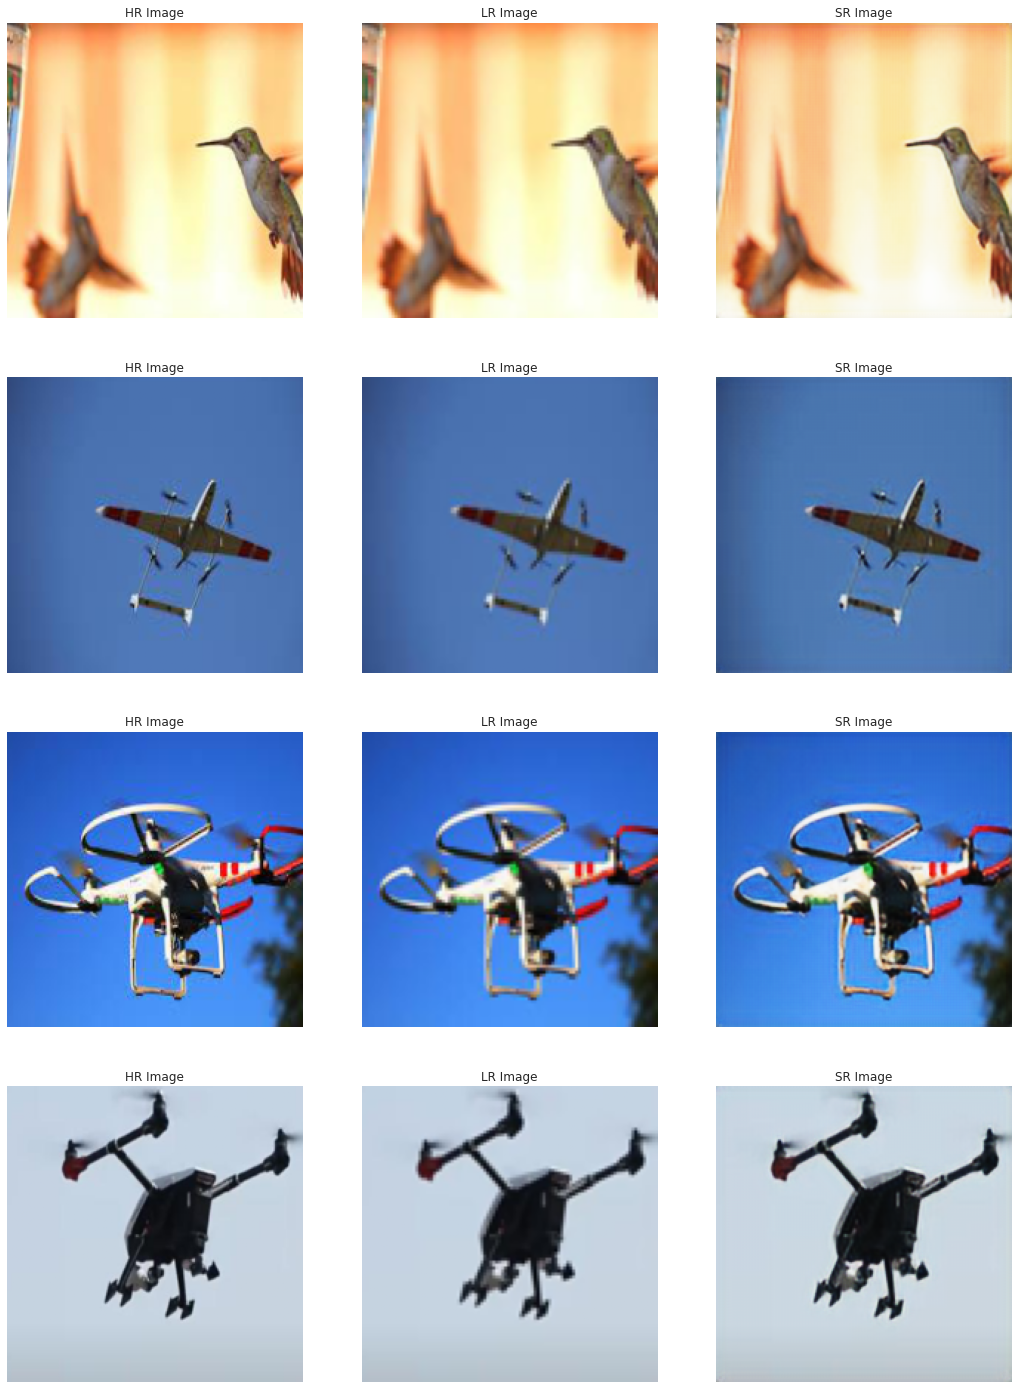

In [123]:
plot_outputs(hr_images[:4], lr_images[:4], recon_out[:4])

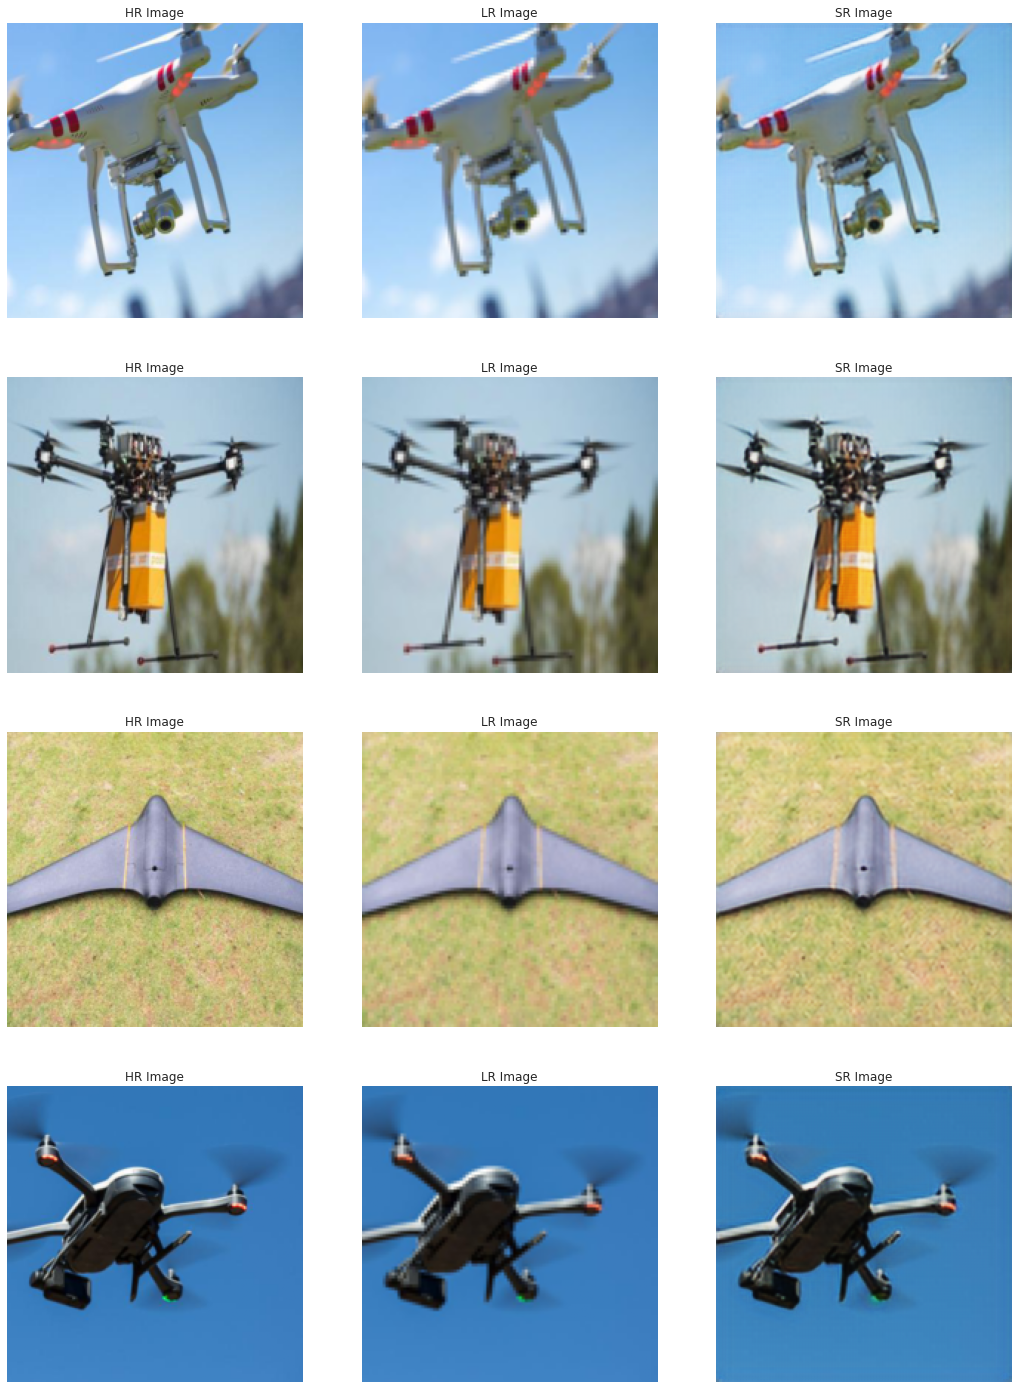

In [124]:
plot_outputs(hr_images[5:9], lr_images[5:9], recon_out[5:9])

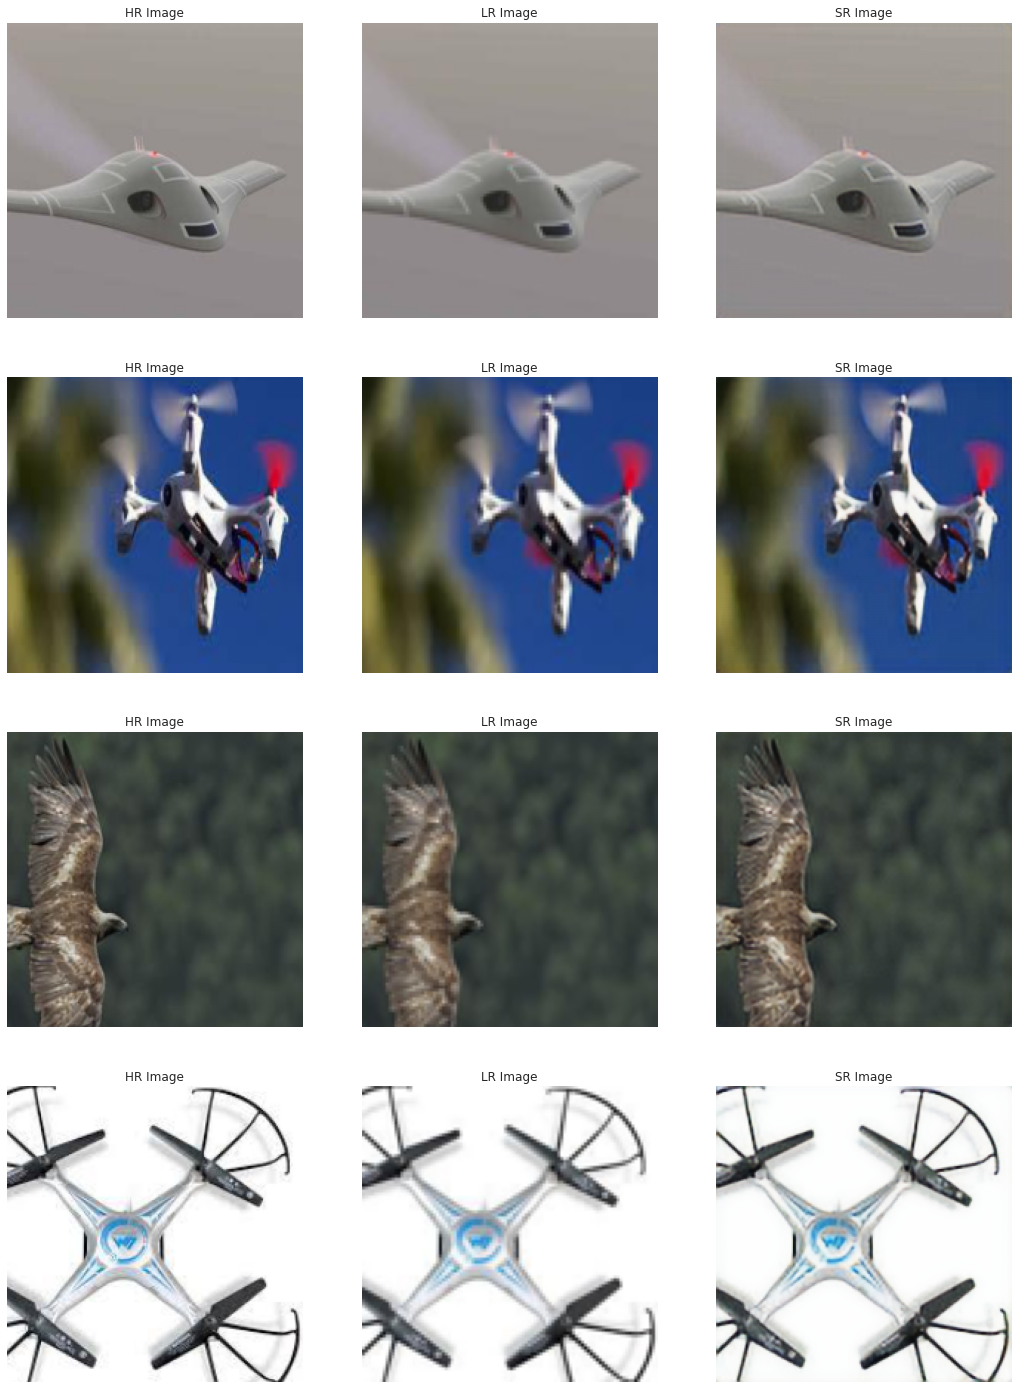

In [125]:
plot_outputs(hr_images[9:13], lr_images[9:13], recon_out[9:13])

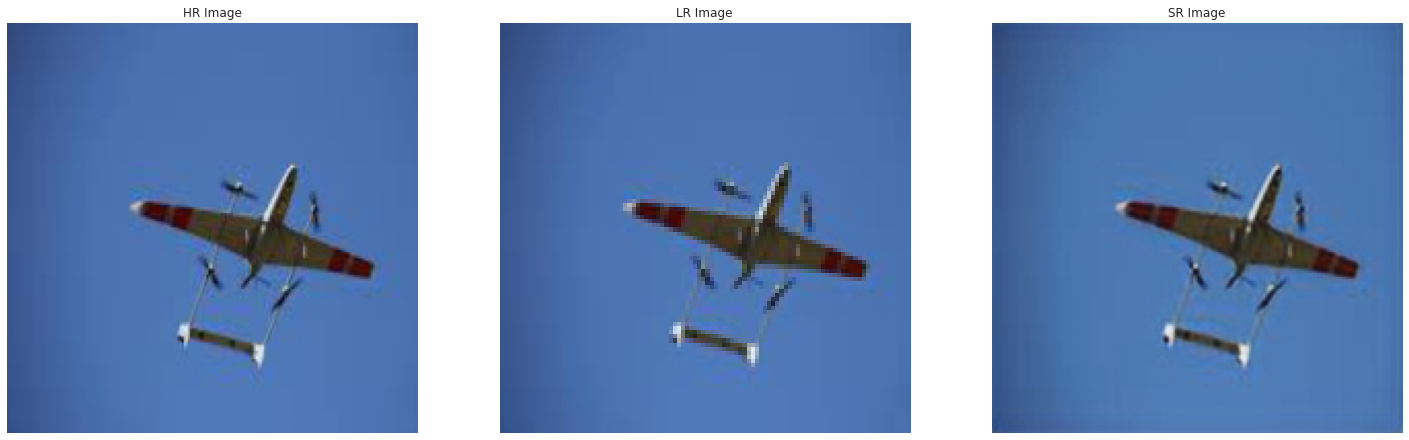

In [94]:
plot_output(hr_images[1], lr_images[1], recon_out[1])

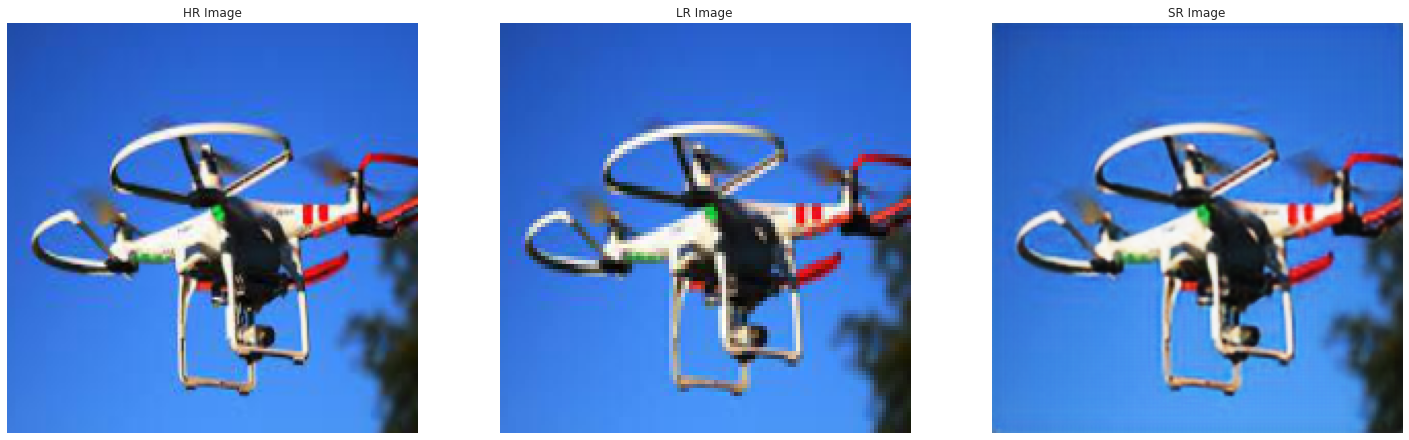

In [95]:
plot_output(hr_images[2], lr_images[2], recon_out[2])

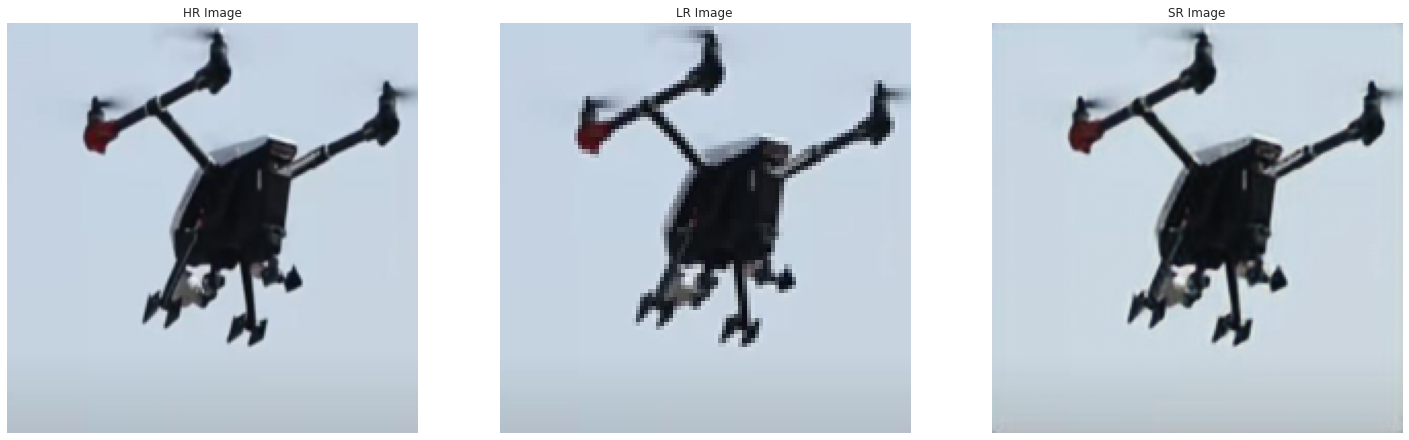

In [96]:
plot_output(hr_images[3], lr_images[3], recon_out[3])

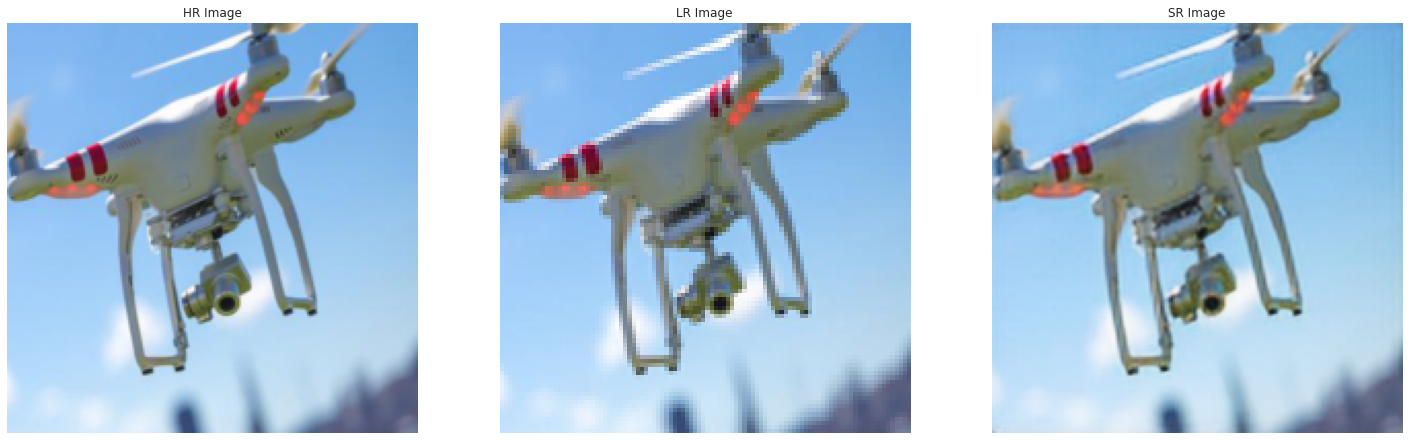

In [98]:
plot_output(hr_images[5], lr_images[5], recon_out[5])